# **Exploring venues in Dehradun, India - 248002**

## **Table of Contents**
 
 - Introduction
 - Data Collection from API's
 - Data Cleaning
 - Methodology
 - Analysis
 - Results
 - Discussion
 
## **Introduction**
The aim of the project is to identify venues in Dehradun, India based on their rating and average prices. In this notebook, we will identify various venues in the city of Dehradun, India, using Foursquare API and Zomato API, to help visitors select the restaurants that suit them the best.

Whenever a user is visiting a city they start looking for places to visit during their stay. They primarily look for places based on the venue ratings across all venues and the average prices such that the location fits in their budget.

Here, we'll identify places that are fit for various individuals based on the information collected from the two APIs and Data Science. Once we have the plot with the venues, any company can launch an application using the same data and suggest users such information.

## **Data Collection from API's**
To begin with, we will take a look at **Dehradun** on the Map using the folium library.

We will also fetch the data from two different APIs.

 - **Foursquare API**: We will use the Foursquare API to fetch venues in Pune starting from the middle upto a 5 kilometer radius.
 - **Zomato API**: The Zomato API provides information about various venues including the complete address, user ratings, price for two people, price range and a lot more.
 
### **Dehradun**
Dehradun is spread across a total area of 300 sq Km. There are many venues (especially restaurants, hotels and cafes) which can be explored.
We will get started by importing the required libraries from python for our task.

In [59]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
import requests

import folium

from sklearn.cluster import KMeans

In [60]:
TARGET_LATITUDE = 30.3253
TARGET_LONGITUDE = 78.0413
TARGET = "Clock Tower, Dehradun"

print("The geographical coordinates of {} are {} and {}.".format(TARGET, TARGET_LATITUDE, TARGET_LONGITUDE))

The geographical coordinates of Clock Tower, Dehradun are 30.3253 and 78.0413.


Let's use the folium library to create a **complete map zoomed on Dehradun**. We'll also plot a marker on the coordinates we just identified above. This would give us a relatively good look at the center point we will be considering.

In [61]:
target_location_map = folium.Map(location = [TARGET_LATITUDE, TARGET_LONGITUDE], zoom_start = 13)
folium.Marker([TARGET_LATITUDE, TARGET_LONGITUDE]).add_to(target_location_map)
target_location_map

### **Foursquare API**

We begin by fetching a total of all venues in Dehradun upto a range of 5 Kilometers using the Foursquare API. The Foursquare API has the explore API which allows us to find venue recommendations within a given radius from the given coordinates. We will use this API to find all the venues we need.

In [107]:
# The code was removed by Watson Studio for sharing.

In [106]:
RADIUS = 5000 
NO_OF_VENUES = 70
VERSION = '20200720' 

We define the get_category_type method to get the correct category for each venue.

In [63]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    
    if(len(categories_list)==0):
        return None
    else:
        return categories_list[0]['name']

We'll call the API over and over till we get all venues from the API within the given distance. The maximum venues this API can fetch is 100, so we will fetch all venues by iteratively calling this API and increasing the offset each time.
 
 - Foursquare API requires client_id, and client_secret to function which can be accessed after creating a developer account.
 - We will set the radius as 5 kilometers.
 - The version is a required parameter which defines the date on which we are browsing so that it retrieves the latest data.

In [64]:
offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FOURSQUARE_CLIENT_ID, 
                                                                        FOURSQUARE_CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        TARGET_LATITUDE, 
                                                                        TARGET_LONGITUDE, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))


Total 30 venues fetched within a total radius of 5.0 Km

Total 30 venues fetched


### **Zomato API**

The Zomato API allows using its search API to search for any given venue based on certain search filters such as query, latitude, longitude and more. Zomato also requires a Zomato user key which can be accessed with a developer account.

We'll use the name, lat, and lng values of various venues fetched from Foursquare API to use the search API and get more information regarding each venue.

 - The query will be the name of the venue.
 - The start defines from what offset we want to start, so we'll keep it at 0.
 - The count defines the number of restaurants we want to fetch. As we have the exact location coordinates, we'll fetch only one.
 - We will supply the latitude and longitude values.
 - We will set the sorting criteria as real_distance so each time we get the venue we're searching based on location coordinates.

In [65]:
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    try:
        result = requests.get(url, headers = headers).json()
    except:
        print("There was an error...")
    try:
        
        if (len(result['restaurants']) > 0):
            venue.append(result['restaurants'][0]['restaurant']['name'])
            venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
            venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
            venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
            venue.append(result['restaurants'][0]['restaurant']['price_range'])
            venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
            venue.append(result['restaurants'][0]['restaurant']['location']['address'])
            venues_information.append(venue)
        else:
            venues_information.append(np.zeros(6))
    except:
        pass
        
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])


Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30


In [66]:
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

## **Data Cleaning**

The data from multiple resources might not always align. Thus, it is **important to combine the data retrieved from multiple resources properly**.

We'll first plot the two data points on the map. We'll then try to combine data points that have their latitude and longitude values very close to one another. From the remaining selected venues, we will inspect the venues to ensure that any remaining mismatched venues are also removed from the final dataset of venues before we begin any analysis.

We will first plot the Foursquare data on the map.

In [67]:
target_location_map = folium.Map(location = [TARGET_LATITUDE, TARGET_LONGITUDE], zoom_start = 13)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(target_location_map)  

target_location_map

We will also plot the Zomato data on the map.

In [68]:
target_location_map = folium.Map(location = [TARGET_LATITUDE, TARGET_LONGITUDE], zoom_start = 13)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    UPDATED_LG = float(longitude)
    UPDATED_LT = float(latitude)
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [UPDATED_LT, UPDATED_LG],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(target_location_map)  

target_location_map

To combine the two datasets, I'll have to check that the latitude and longitude values of each corresponding venue match. Thus, I'll round both the latitude and longitude values upto 4 decimal places. Then, I'll calculate the difference between the corresponding latitude and longitude values and see if the difference is less than 0.0004 which should ideally mean that the two locations are same.

In [69]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [70]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [88]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Anandam,Indian Restaurant,30.3353,78.0532,Anandam,30.3351,78.0533,650,3,4.4,"69, Krishna Tower, Rajpur Road, Hathibarkala S...",-0.0002,0.0001
1,KFC,Fast Food Restaurant,30.3338,78.0515,KFC,30.3336,78.0516,450,2,4.2,"65A, Rajpur Road, Hathibarkala Salwala, Dehradun",-0.0002,0.0001
2,Ellora Bakers And Confectioners,Bakery,30.3287,78.0464,Ellora Homeaids,30.3288,78.0463,300,2,3.8,"25, Rajpur Road, Chukkuwala, Dehradun",0.0001,-0.0001
3,Paltan Bazaar,Flea Market,30.3231,78.0406,31 Flavours,30.3230,78.0406,350,2,3.6,"39, Paltan Bazar Road, Paltan Bazaar, Dehradun",-0.0001,0.0000
4,Black Pepper,Indian Restaurant,30.3283,78.0465,Black Pepper Restaurant,30.3279,78.0464,800,3,4.3,"3, First and Second Floor, Astley Hall, Rajpur...",-0.0004,-0.0001
5,Kalsang Friends Corner,Thai Restaurant,30.3469,78.0628,Kalsang Friends Corner,30.3469,78.0625,800,3,4.6,"opp - OSHO ,88/A, Rajpur Road, Dehradun",0.0000,-0.0003
6,Silver City Multiplex,Multiplex,30.3429,78.0603,Punjabi Lassi Bar Restaurant,30.3429,78.0604,200,1,0,"Tarli Kandoli, Near Silver City Mall, Rajeev N...",0.0000,0.0001
7,Pizza Hut,Pizza Place,30.3426,78.0607,Pizza Hut,30.3425,78.0608,600,3,3.7,"542, Rajpur Road, Dehradun Nagar Nigam, Salwal...",-0.0001,0.0001
8,cafe coffee day,Coffee Shop,30.3227,78.0428,Cafe Coffee Day,30.3224,78.0430,500,3,3.7,"Darshan Lal Chowk, Near Clock Tower, Race Cour...",-0.0003,0.0002
9,Barista Lavazza,Café,30.3268,78.0450,Barista,30.3269,78.0449,500,3,3.7,"15 A, English Book Depot, Rajpur Road, Chukkuw...",0.0001,-0.0001


I'll now select the venue name from Zomato API. I'll also get the average price per person by dividing the column price_for_two by 2 and removing this column from the dataset along with other unnecessary columns.

In [89]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

Let's take a look at the final dataset that is left with us.

In [90]:
selected_venues.head()

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Indian Restaurant,Anandam,30.3351,78.0533,3,4.4,"69, Krishna Tower, Rajpur Road, Hathibarkala S...",325.0
1,Fast Food Restaurant,KFC,30.3336,78.0516,2,4.2,"65A, Rajpur Road, Hathibarkala Salwala, Dehradun",225.0
2,Bakery,Ellora Homeaids,30.3288,78.0463,2,3.8,"25, Rajpur Road, Chukkuwala, Dehradun",150.0
3,Flea Market,31 Flavours,30.3230,78.0406,2,3.6,"39, Paltan Bazar Road, Paltan Bazaar, Dehradun",175.0
4,Indian Restaurant,Black Pepper Restaurant,30.3279,78.0464,3,4.3,"3, First and Second Floor, Astley Hall, Rajpur...",400.0


I'll drop the venues which have 0.0 rating as it means it's not been rated yet.

In [91]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 15


## **Methodology**

This project aims at identifying the venues in Dehradun based on their rating and average costs. This would enable any visitor to identify the venues he/she wants to visit based on their rating and cost preference.

As a first step, we retrieved the data from two APIs(Foursquare and Zomato). We extract venue information from the center of Dehradun, upto a distance of 5 Km. The latitude and longitude values are then used to fetch venue rating and price from Zomato.

Secondly, we explore the data retrieved from the two APIs on the map and identify the top category types. The data from the two sources is carefully combined based on the name, latitude and longitude values from the two sources. The final dataset would include the rating and price values for each venue.

Next, we'll analyse the data that we created based on the ratings and price of each venue. We'll identify places where many venues are located so that any visitor can go to one place and enjoy the option to choose amongst many venue options. We'll also explore areas that are high rated and those that are low rated while also plotting the map of high and low priced venues. 

Lastly, we'll cluster the venues based on the available information of each venue. This will allow us to clearly identify which venues can be recommended and with what characteristics.

Finally, we'll discuss and conclude which venues to be explored based on visitor's requirement of rating and cost.

## **Analysis**

The complete dataset is now in its final form.

We will inspect these venues based on their rating. The rating of a venue is based on user reviews and belongs to a range from 1 to 5. We'll also analyse the venues based on their price per person as well as the price range.

### Categories

We have various types of venues in the final dataset. We will take a look at the venues and check which are the majority venue categories in the list.

<BarContainer object of 11 artists>

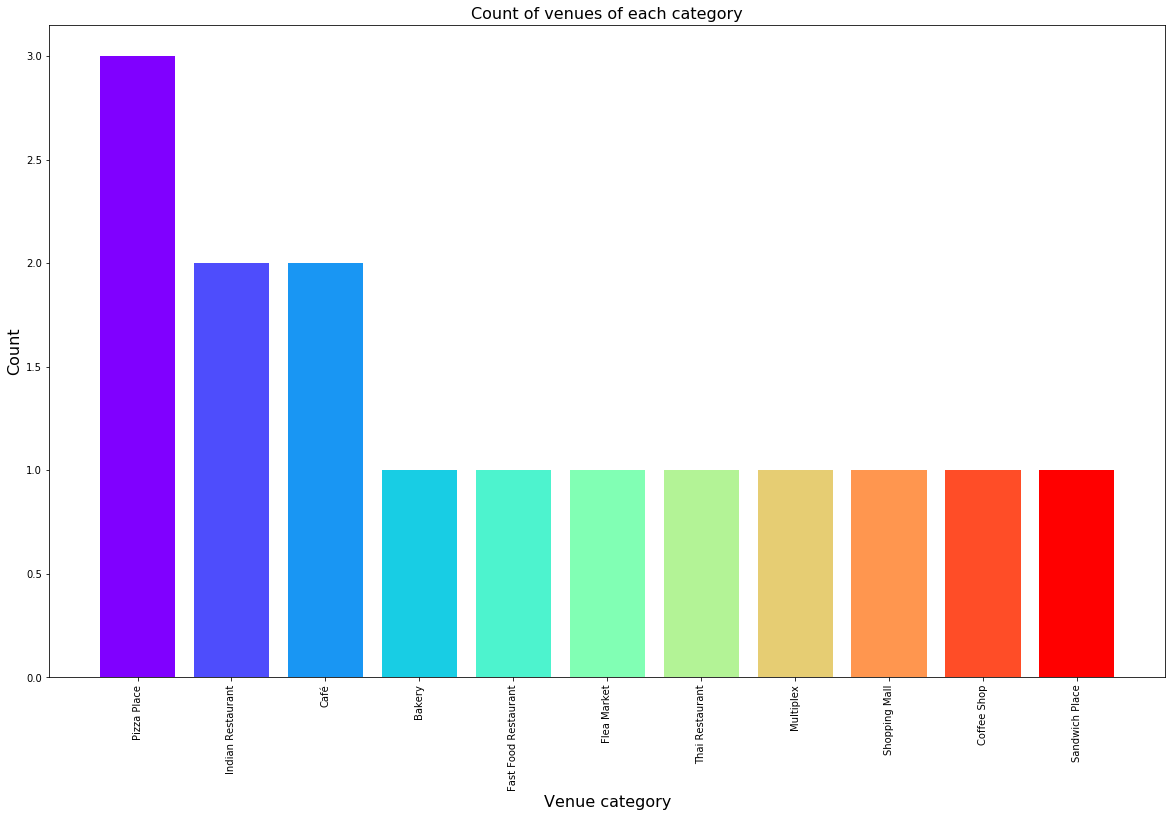

In [92]:
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

As we can see the majority venues are Pizza Place, Indian Restaurant and Cafe. So, if as a tourist, you're looking for cafes and Indian restaurants, you're in luck. To top it off plenty of pizza places never hurt anyone.

### Rating

Rating of a venue is an important factor on which a visitor decides whether it is worth it to visit the place or not. To cater to this, we will first see what is the average rating for all the venues in the city. Next, we will plot the venues on the map and color code them.

We'll first identify the various rating values and plot them as a bar plot with their counts to see the most common rating.

Text(0.5, 1.0, 'Count of venues with given rating')

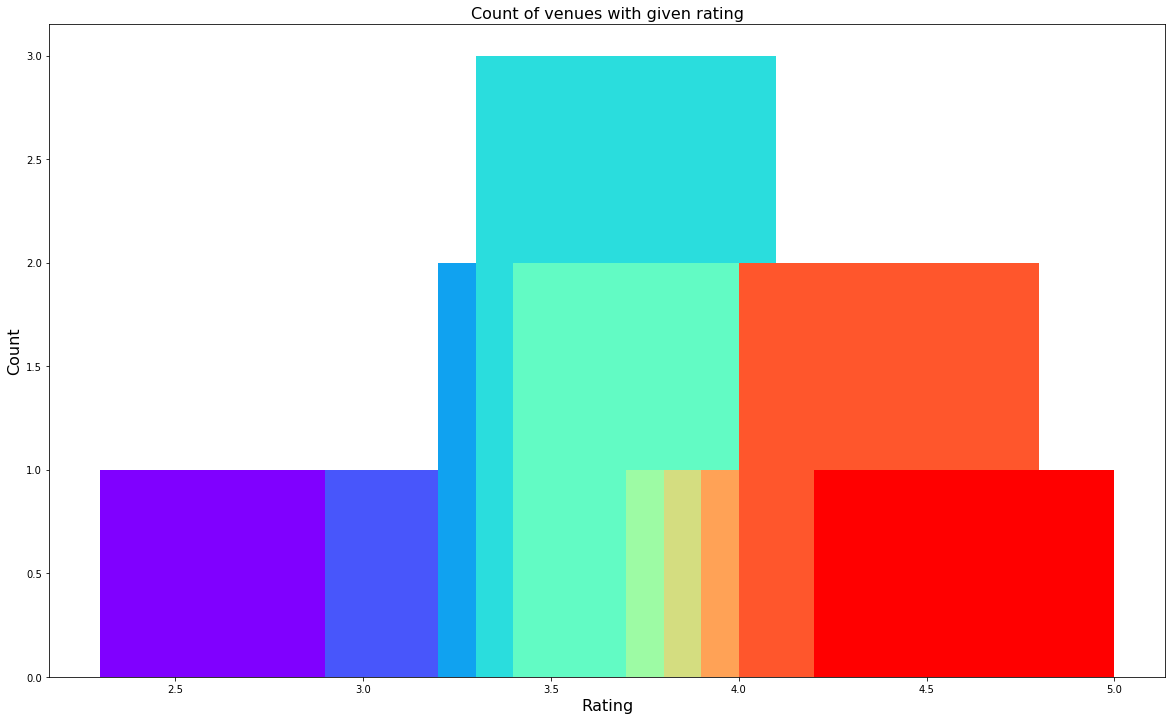

In [93]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

From the plot above, it is clear that majority venues have their rating close to 4.

Let's create bins for various ratings and plot them in different colors on the map. The ratings will be divided between 4 bins:

 - 1 to 2
 - 2 to 3
 - 3 to 4
 - 4 to 5

In [94]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

Now we will plot the venues on the map.

In [95]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}

target_location_map = folium.Map(location = [TARGET_LATITUDE, TARGET_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(target_location_map)  

target_location_map

The map has the location of all the venues. It appears that many venues are located around Chakrata Road, Gandhi Road junction and Rajpur Mussorie Road with rating above 3. If someone wants to explore new venues, they should definitely check out these areas.

### Price

We will now take a look the venues based on the price values. We have two price features for our venues, one is average_price which defines the average cost for one person and the other is price_range which determines the price range as defined by Zomato.

We will first explore the average_price using a scatter plot between the price and the count of venues with that average price. We'll size the points based on the price to highlight their price.

Text(0.5, 1.0, 'Count of venues with given average price')

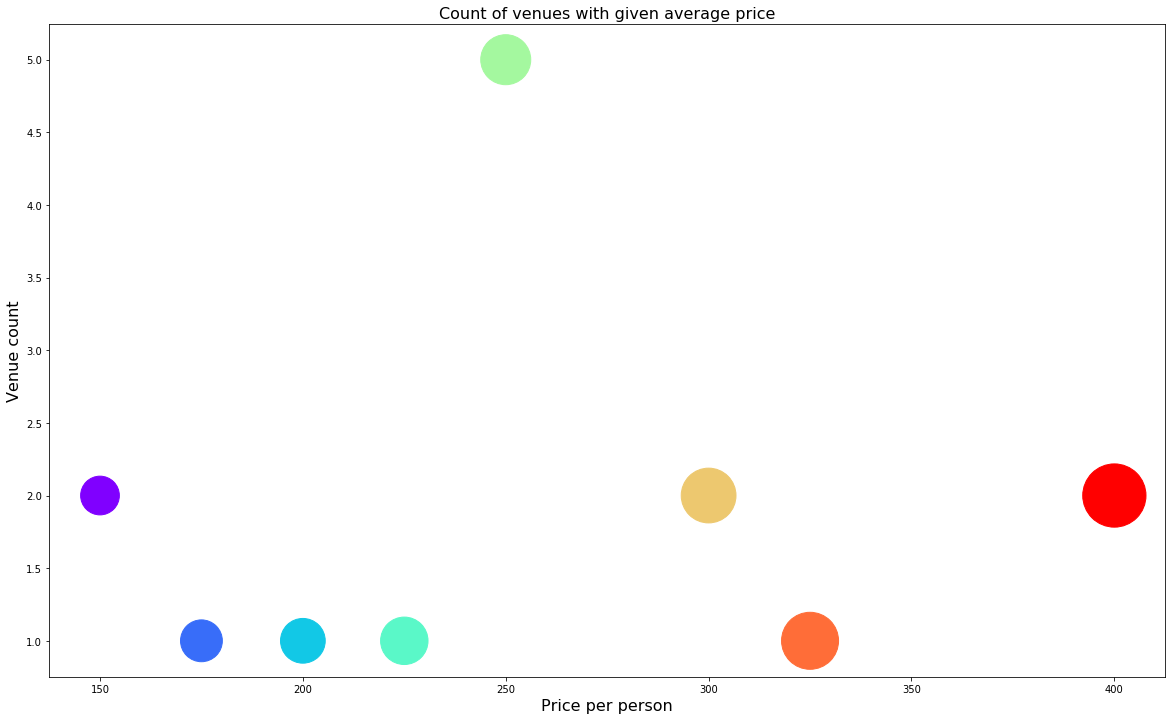

In [96]:
average_prices = selected_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

From the plot above we can see that a large number of venues have an average price between Rs 150 and Rs 300.

Users might also be interested in going to a place that fits in their budget. I'll use the price_range column to plot the venues on a map. We'll represent the venues with lower price in green and move towards red as the price increases.

In [97]:
color_map = {'1': 'green', '2': 'darkgreen', '3': 'orange', '4': 'red'}

target_location_map = folium.Map(location = [TARGET_LATITUDE, TARGET_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(target_location_map)  

target_location_map

We can see that most of the venues on our desired location have a slightly higher price.

### Clustering

We will now cluster all these venues based on their price range, location and more to identify similar venues and the relationship amongst them. We'll cluster the venues into two separate groups.

In [98]:
NO_OF_CLUSTERS = 2

clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues.head()

,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Indian Restaurant,Anandam,30.3351,78.0533,3,4.4,"69, Krishna Tower, Rajpur Road, Hathibarkala S...",325.0,Very good
1,1,Fast Food Restaurant,KFC,30.3336,78.0516,2,4.2,"65A, Rajpur Road, Hathibarkala Salwala, Dehradun",225.0,Very good
2,1,Bakery,Ellora Homeaids,30.3288,78.0463,2,3.8,"25, Rajpur Road, Chukkuwala, Dehradun",150.0,Good
3,1,Flea Market,31 Flavours,30.3230,78.0406,2,3.6,"39, Paltan Bazar Road, Paltan Bazaar, Dehradun",175.0,Good
4,0,Indian Restaurant,Black Pepper Restaurant,30.3279,78.0464,3,4.3,"3, First and Second Floor, Astley Hall, Rajpur...",400.0,Very good


In [99]:
target_location_map = folium.Map(location = [TARGET_LATITUDE, TARGET_LONGITUDE], zoom_start = 13)
color_map = { 0: 'green', 1: 'red'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(target_location_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(target_location_map)

target_location_map

We can see that one cluster is is spread across the junction of Chakrata Road and Gandhi Road while the other one clearly comprises of venues on Rajpur Mussorie Road.

Now let us check the venues in these clusters.

In [100]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Indian Restaurant,Anandam,30.3351,78.0533,3,4.4,"69, Krishna Tower, Rajpur Road, Hathibarkala S...",325.0,Very good
1,0,Indian Restaurant,Black Pepper Restaurant,30.3279,78.0464,3,4.3,"3, First and Second Floor, Astley Hall, Rajpur...",400.0,Very good
2,0,Thai Restaurant,Kalsang Friends Corner,30.3469,78.0625,3,4.6,"opp - OSHO ,88/A, Rajpur Road, Dehradun",400.0,Very good
3,0,Pizza Place,Pizza Hut,30.3425,78.0608,3,3.7,"542, Rajpur Road, Dehradun Nagar Nigam, Salwal...",300.0,Good
4,0,Pizza Place,Pizza Hut,30.3221,78.0033,3,3.8,"C1/101, Indra Nagar, Dehradun Nagar Nigam, Bal...",300.0,Good


In [101]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".format(result['price_range'].mean(), result['rating'].astype(float).mean()))      

These venues for cluster 0 have mean price range of 3.00 and rating spread around 4.16


In [102]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Fast Food Restaurant,KFC,30.3336,78.0516,2,4.2,"65A, Rajpur Road, Hathibarkala Salwala, Dehradun",225.0,Very good
1,1,Bakery,Ellora Homeaids,30.3288,78.0463,2,3.8,"25, Rajpur Road, Chukkuwala, Dehradun",150.0,Good
2,1,Flea Market,31 Flavours,30.3230,78.0406,2,3.6,"39, Paltan Bazar Road, Paltan Bazaar, Dehradun",175.0,Good
3,1,Coffee Shop,Cafe Coffee Day,30.3224,78.0430,3,3.7,"Darshan Lal Chowk, Near Clock Tower, Race Cour...",250.0,Good
4,1,Café,Barista,30.3269,78.0449,3,3.7,"15 A, English Book Depot, Rajpur Road, Chukkuw...",250.0,Good
5,1,Sandwich Place,Subway,30.3255,78.0434,3,4.1,"Bharat Petro Gas C-Store, Rajpur Road, Race Co...",250.0,Very good
6,1,Shopping Mall,Cafe Coffee Day,30.3329,78.0537,3,2.7,"Ground Floor, Crossroads Mall, Karanpur, Dehradun",250.0,Okay
7,1,Multiplex,Giani Ice Cream,30.3222,78.0027,2,3.6,"Vikas Cinema, Indra Nagar, Balliwala, Dehradun",150.0,Good
8,1,Café,Cafe Coffee Day,30.3386,78.0587,3,3.3,"71, Swaraj Complex, Rajpur Road, Kandholi",250.0,Good
9,1,Pizza Place,Domino's Pizza,30.2931,78.0590,2,4.4,"Shop G-001, Ground Floor, Shree Tower, Village...",200.0,Very good


In [103]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 2.50 and rating spread around 3.71


## **Insights on venues in Dehradun**

Based on our analysis above, we can draw a number of conclusions that will be useful to aid any visitor visiting the city of Dehradun, India.

After collecting data from the Foursquare and Zomato APIs, we got a list of 30 different venues. However, not all venues from the two APIs were identical. Hence, we had to inspect their latitude and longitude values as well as names to combine them and remove all the outliers. This resulted in a total venue count of 15.

We identified that from the total set of venues, majority of them were **Pizza Places, Cafes and Indian Restaurants**. A visitor who loves Cafes, Indian Restaurants or Pizza would surely benefit from coming to Dehradun.

Typically a person can have food at a place with a decent rating on the Rajpur Mussorie Road venues while if an individual is willing to spend a bit more he/she can enjoy the best food that the city has to offer in the venues along the junction of Chakrata-Gandhi Road.

Finally, through clusters we identified that there are many venues which are relatively lower priced but have an average rating of 3.71. On the other hand, there are few venues which are high priced and have average rating of 4.16.

A company can use this information to build up an online website/mobile application, to provide users with up to date information about various venues in the city based on the search criteria(name, rating and price).

## **Conclusion**

The purpose of this project was to explore the places that a person visiting Dehradun could visit. The venues have been identified using Foursquare and Zomato API and have been plotted on the map. The map reveals that there are two major areas a person can visit: Chakrata-Gandhi Road junction & Rajpur Mussorie Road. Based on the visitor's venue rating and price requirements, he/she can choose amongst the three places.